In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
import math
from aero_info import table_atm, Cx43
import timeit

# 1) Баллистическое проектирование ЗУР

Для начала проинтегрируем систему, приняв угол **thetta (Q)** постоянным и исключив 2-ое уравнение системы (dQ/dt)

In [ ]:
# Пример формирования словаря с начальными данными одноступенчатой ракеты (аналог - ЗУР 48Н6E ЗРС С-300 ПМУ-1)
opts = {
    'init_conditions': {'l_pusk': 9,
                        'x': 0,
                        'y': 50,
                        'v': 25,
                        'thetta': 60},
    'η_0': 14,
    'I_10': 2600,
    'myu_0': 0.6,
    'lambda_e': 2.373,
    'k': 1.21,
    'p_00': 5*1e6,
    'q_M': 88000,
    'i': 1.05,
    'integr': {'stop_conditions': 'x_max',
               'value': 2e5,
               'dt': 1e-1}
}  

In [ ]:
def ozvb(dict_opts):
    
    """
    Ф-ция решения прямой задачи внешней баллистики (ОЗВБ) ракеты
    :argument:  dict_opts {dict}  -- словарь с опциями (начальными данными)
    :return:    dict_res  {dict}  -- словарь с результатами решения ОЗВБ
    """
    
    # const:
    g     = 9.80665
    p_h0  = 101325
    k_air = 1.41
    
    def func_stop(stop_conditions):
        if stop_conditions == 't0':
            return lambda t: dict_opts['I_10'] * dict_opts['myu_0'] / dict_opts['η_0'] / g - t
        if stop_conditions == 'v_max':
            return lambda v: dict_opts['integr']['value'] - v
        if stop_conditions == 'y_max':
            return lambda y: dict_opts['integr']['value'] - y
        if stop_conditions == 'x_max':
            return lambda x: dict_opts['integr']['value'] - x
        if stop_conditions == 'step_max':
            return lambda i: dict_opts['integr']['value'] - i
        if stop_conditions == 't_max':
            return lambda t: dict_opts['integr']['value'] - t

    def f(λ, k):
        # табличная газодинамическая функция
        return (1 + λ ** 2) * (1 - ((k - 1) / (k + 1)) * λ ** 2) ** (1 / (k - 1))

    def π(y):
        # ф-ция изменения атмосф. давления с высотой
        p_h = table_atm(y, 2)
        return p_h / p_h0

    def ξ_stage(μ, μ_0):
        # ф-ция, учитывающая отстыковку стартовой ступени (для двухступенчатых ракет)
        if μ < μ_0:
            return 1
        else:
            return 0
   
    def ξ_pusk(x, y):
        # ф-ция, учитывающая неизменность угла наклона траектории при движении ракеты по направляющей
        if np.sqrt(x ** 2 + y ** 2) <= dict_opts['init_conditions']['l_pusk']:
            return 0
        else:
            return 1

    def system(t, Y, r=dict_opts, Cx=Cx43):
            
        y1 = Y[0] # v
        y2 = Y[1] # θ
        y3 = Y[2] # x
        y4 = Y[3] # y
        y5 = Y[4] # μ 
        
        M  = y1 / table_atm(y4, 4)
        
        a10_1 = g * r['η_0'] / (1 - y5)
        a10_2 = g * r['η_0'] * (1 - π(y4)) / ((f(r['lambda_e'], r['k']) * (r['p_00'] / p_h0) - 1) * (1 - y5))
        a1_3  = g * r['i'] * Cx(M) * k_air * p_h0 * π(y4) * (M ** 2) / (2 * r['q_M'] * (1 - y5))
        a1_4  = g * np.sin(y2)
        
        # dv/dt
        f1 = (a10_1 + a10_2) * ξ_stage(y5, r['myu_0']) - a1_3 - a1_4
        # dθ/dt
        f2 = g * ξ_pusk(y3, y4) / (y1 ** (ξ_pusk(y3, y4))) * (Cy_alpha * alpha * table_atm(y4, 3) * y1 ** 2 / (2 * r['q_M'] * (1 - y5)) + r['η_0'] * np.sin(np.radians(alpha)) / (1 - y5) - np.cos(y2))
        # dx/dt
        f3 = y1 * np.cos(y2)
        # dy/dt
        f4 = y1 * np.sin(y2)
        # dμ/dt
        f5 = g * (r['η_0'] / r['I_10']) * ξ_stage(y5, r['myu_0'])
        
        return np.array([f1, f2, f3, f4, f5])
   
    def RK4(F, Y0, stop_conditions=dict_opts['integr']['stop_conditions'],
            func_end=func_stop(dict_opts['integr']['stop_conditions']), 
            dt=dict_opts['integr']['dt'], y=dict_opts['init_conditions']['y'],
            t0=0, max_time=300): 
        
        ti = t0 
        Yi = Y0
        res = {
        'y1': [Y0[0]],
        'y2': [Y0[1]],
        'y3': [Y0[2]],
        'y4': [Y0[3]],
        'y5': [Y0[4]],
        't': [t0],
        'stop_reason': ''        
        }

        def foo_init_stop(stop_conditions, fint, *args):
            if stop_conditions == 't0':
                if fint == 1:
                    return args[1]
                if fint == 0:
                    return t0
            elif stop_conditions == 'v_max':
                if fint == 1:
                    return args[0][0]
                if fint == 0:
                    return Y0[0]
            elif stop_conditions == 'y_max':
                if fint == 1:
                    return args[0][3]
                if fint==0:
                    return Y0[3]
            elif stop_conditions == 'x_max':
                if fint == 1:
                    return args[0][2]
                if fint == 0:
                    return Y0[2]
            elif stop_conditions == 't_max':
                if fint == 1:
                    return args[1]
                if fint == 0:
                    return t0
            else:
                print('unknown condition')
        
        flag = True
        var = foo_init_stop(stop_conditions, 0, Yi, ti)
        
        while func_end(var) > 0 and ti < max_time and flag == True:
            
            k1 = F(ti, Yi)
            k2 = F(ti + dt / 2, Yi + k1 * dt / 2)
            k3 = F(ti + dt / 2, Yi + k2 * dt / 2)
            k4 = F(ti + dt, Yi + k3 * dt)
            Yi += dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6
            
            ti += dt
            if Yi[3] <= 0:
                flag = False
            
            var = foo_init_stop(stop_conditions, 1, Yi, ti)
            
            res['y1'].append(Yi[0])
            res['y2'].append(Yi[1])
            res['y3'].append(Yi[2])
            res['y4'].append(Yi[3])
            res['y5'].append(Yi[4])
            res['t'].append(ti)
            
        if func_end(var) < 0:
            stop_reason = dict_opts['integr']['stop_conditions']
        elif ti >= max_time:
            stop_reason = 'max_time'
        elif Yi[3] <= 0:
            stop_reason = f'missile arrived (x = {Yi[2]}; y = 0)'
        else:
            stop_reason = 'unknown reason'
        res['stop_reason'] = stop_reason
        print(f'stop reason: {stop_reason};\nflight time: {ti} с.;')
        
        return res
    
    init = [dict_opts['init_conditions']['v'], np.radians(dict_opts['init_conditions']['thetta']),
            dict_opts['init_conditions']['x'], dict_opts['init_conditions']['y'], 0]
    
    fl_start = timeit.default_timer()
    res = RK4(system, init)
    fl_end   = timeit.default_timer() - fl_start 
    print(f'execution time: {fl_end} с.')
    
    dict_res = {
        'v': np.array(res['y1']),
        'thetta': np.array(res['y2']),
        'x':  np.array(res['y3']),
        'y': np.array(res['y4']),
        'myu':  np.array(res['y5']),
        't':  np.array(res['t']),
        'stop_reason': res['stop_reason'],
        'execution_time': fl_end
    }

    return dict_res

In [ ]:
def m_0(V_0, Q_0, η_0, V_н, I_10, α_д, m_пн, B=2*1e-5):
    χ = 1 - B * V_0**2 / (3 * η_0) - np.sin(Q_0) / η_0
    μ_0 = 1 - np.exp(- (V_0 - V_н) / (I_10))
    return m_пн / (1 - (1 + α_д) * μ_0)

In [ ]:
V_max = 2100
V_min = 1000

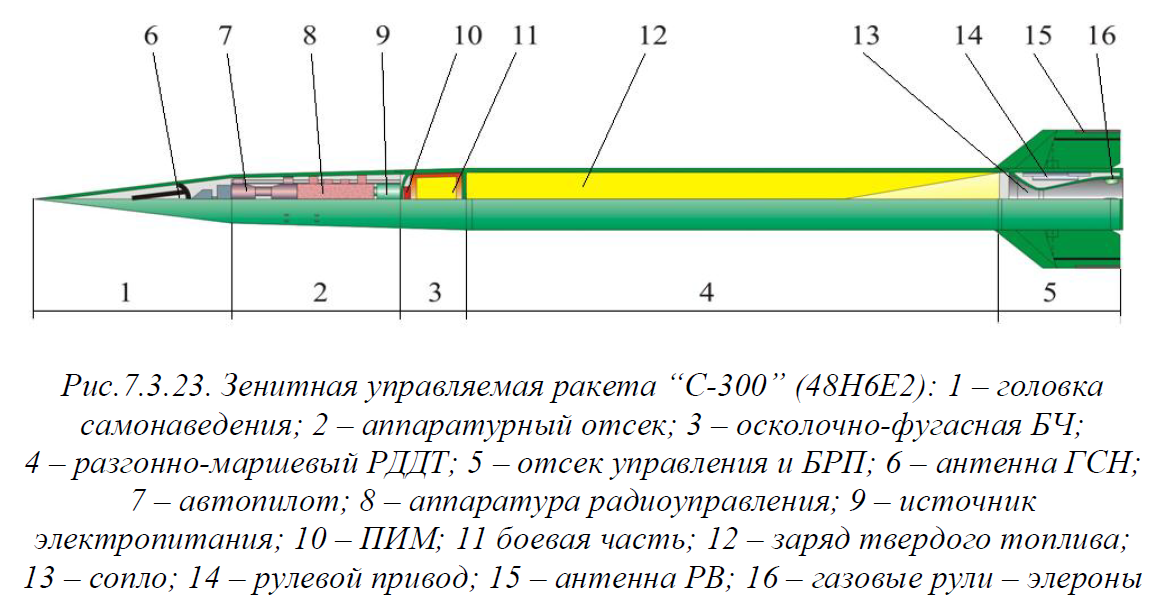

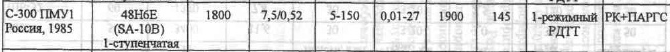

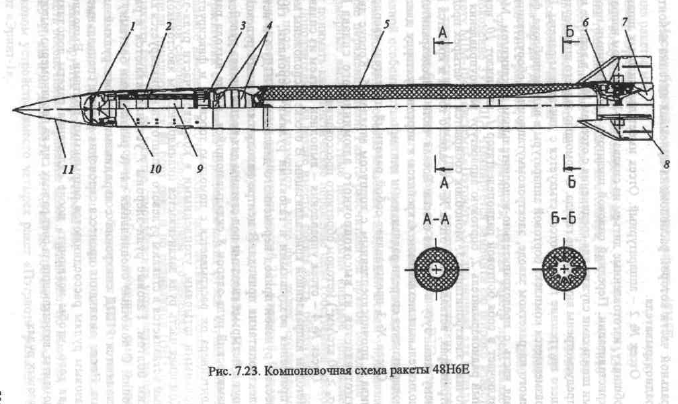

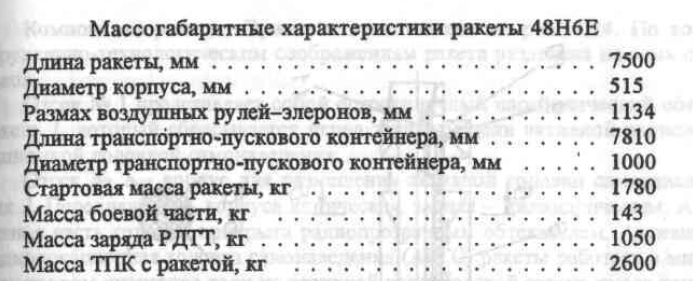

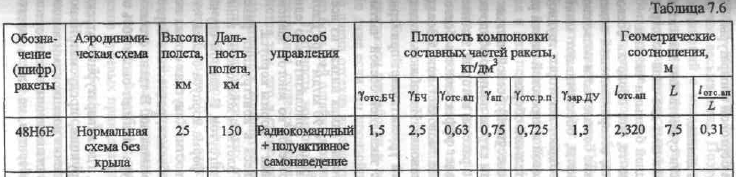

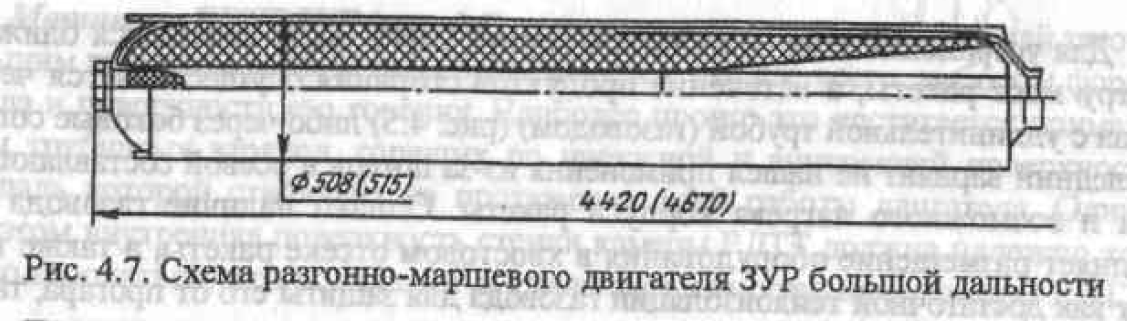

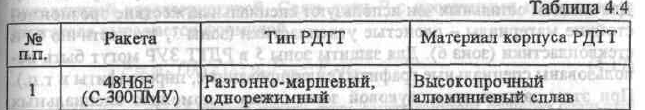

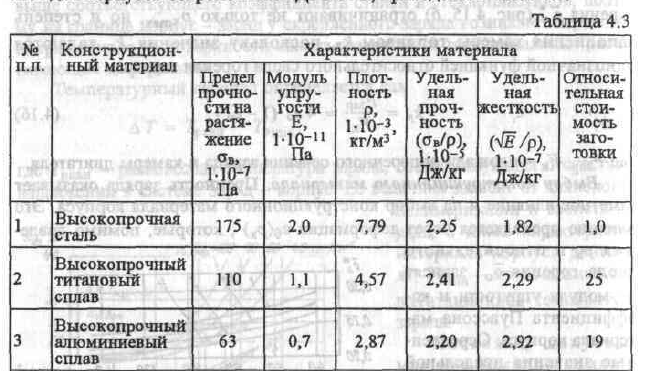

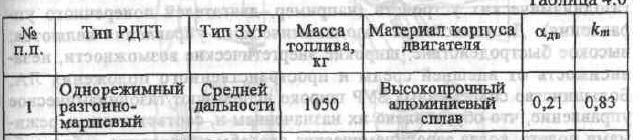

Бескрылая нормальная схема (частный случай "нормальной" схемы) - "схема с несущим корпусом"

АД ОУ - рули-элероны выполняют еще и роль стабилизирующих поверхностей, обеспечивающих необходимые запасы статической устойчивости.

* стр. 455 про бескрылую схему можно многое узнать

* стр. 511 про нашу ракету написал Грушин

* стр. 527 про бал проектирование

In [ ]:
# P(t)  не забыть в Сх_дно
# площадь обтекаемая потоком без среза донного
# демфирующие моменты

In [ ]:
def aero_coef(state, action, n_y_a):
    """
    Ф-ция расчёта аэродинамических коэффициентов ракеты в состоянии state
    arguments: state {np.ndarray} -- состояние ракеты; 
                                     [v,   x, y, Q,       alpha,   t]
                                     [м/с, м, м, радианы, градусы, с]
               action {int}       -- управляющее воздействие на протяжении шага;
    return:
    """
    a = 0.2 # коэффициент согласования (0,15...0,2)
    L_korp =
    L_nos =
    L_cil =
    L_korm =
    L_oper =
    b_0_oper =
    betta_kon1 = # полугол при вершине 1-ого конуса, град
    betta_kon2 = # полугол при вершине 2-ого конуса, град
    d_kon1 = # диаметр наибольшего сечения переднего конуса
    d = 
    d_korm =
    L_oper = 
    S_oper = 
    c_oper, khi_pk_oper = 0.03, 
    khi_rul = # угол оси вращения руля, град
    class_korp = 7
    class_oper = 5
    x_b_a_oper
    x_b_oper
    L_hv_oper
    x_ct
    # mz_cy = - 0.02...0.06 для обычной схемы (x_t - x_fa) / L_korp
    
    
    v, x, y, Q, alpha = state[0], state[1], state[2], state[3], state[4]
    Mach = v / table_atm(y, 4)
    nyu = table_atm(y, 6)
    Re_korp_f = v * L_korp / nyu
    Re_korp_t = table_4_5(Mach, Re_korp_f, class_korp, L_korp)
    
    
    # Вычисление геометрии корпуса:
    S_kon1 = np.pi * d_kon1**2 / 4
    S_mid = np.pi * d**2 / 4
    F_f = # площадь обтекаемая потоком без среза донного
    W_nos = 1/3 * L_nos * S_mid
    lambd_korp = L_korp / d
    lambd_nos = L_nos / d
    lambd_cil = L_cil / d
    lambd_korm = L_korm / d
    nu_korm = d_korm / d
    
    
    # Вычисление геометрии рулей (оперения):
    D_oper = d / L_oper
    tg_khi_pk_oper = np.tan(np.radians(khi_pk_oper))
    lambd_oper = L_oper**2 / S_oper
    nu_oper = (S_oper / (L_oper * b_0_oper) - 0.5) ** (-1) / 2
    b_k_oper = b_0_oper / nu_oper
    b_a_oper = 4 / 3 * S_oper / L_oper * (1 - (nu_oper / (nu_oper + 1) ** 2))
    b_b_oper = b_0_oper * (1 - (nu_oper - 1) / nu_oper * d / L_oper)
    z_a_oper = L_oper / 6 * ((nu_oper + 2) / (nu_oper + 1))
    L_k_oper = L_oper - d
    S_k_oper = S_oper * (1 - ((nu_oper - 1) / (nu_oper + 1)) * d / L_oper) * (1 - d / L_oper)
    nu_k_oper = nu_oper - d / L_oper * (nu_oper - 1)
    lambd_k_oper = lambd_oper * ((1 - d / L_oper) / (1 - ((nu_oper - 1) / (nu_oper + 1) * d / L_oper)))
    tg_khi_05_oper = tg_khi_pk_oper - 2 / lambd_oper * (nu_k_oper - 1) / (nu_k_oper + 1)
    K_oper = 1 / (1 - a_oper / b_a_oper)

    
    # Коэф-т подъемной силы корпуса
    if Mach <= 1:
        Cy_alpha_nos = 2 / 57.3 * (1 + 0.27 * Mach**2)
    else:
        Cy_alpha_nos = 2 / 57.3 * (np.cos(np.radians(betta_kon1))**2 * S_kon1 / S_mid
                                   + np.cos(np.radians(betta_kon2))**2 * (1 - S_kon1 / S_mid))
    Cy_alpha_korm = - 2 / 57.3 * (1 - nu_korm ** 2) * a
    Cy_alpha_korp = Cy_alpha_nos + Cy_alpha_korm
    
    
    # Коэф-т подъемной силы оперения по углу атаки
    K_t_oper = table_3_21(Mach, lambd_nos)
    Cy_alpha_k_oper = Cy_alpha_iz_kr(Mach * np.sqrt(K_t_oper), lambd_oper, c_oper, tg_khi_05_oper)
    k_aa_oper = (1 + 0.41 * D_oper)**2 * ((1 + 3 * D_oper - 1 / nu_k_oper * D_oper * (1 - D_oper)) / (1 + D_oper)**2)
    K_aa_oper = 1 + 3 * D_oper - (D_oper * (1 - D_oper)) / nu_k_oper
    Cy_alpha_oper = Cy_alpha_k_oper * K_aa_oper
    
    
    # Коэф-т подъемной силы оперения (рулей) по углу их отклонения
    K_delt_0_oper = k_aa_oper
    k_delt_0_oper = k_aa_oper ** 2 / K_aa_oper
    if Mach <= 1:
        k_shch = 0.825
    elif 1 < Mach <= 1.4:
        k_shch = 0.85 + 0.15 * (Mach - 1) / 0.4
    else:
        k_shch = 0.975
    n_eff = k_shch * np.cos(np.radians(khi_rul))
    Сy_delt_oper = Cy_alpha_k_oper * K_delt_0_oper * n_eff
    
    
    # Коэф-т подъемной силы ракеты
    Cy_alpha = Cy_alpha_korp * (S_mid / S_mid)  + Cy_alpha_oper * (S_oper / S_mid) * K_t_oper    
      
    
    # Сопротивление корпуса
    x_t = Re_korp_t * nyu / v
    x_t_ = x_t / L_korp
    Cx_f_ = table_4_2(Re_korp_f, x_t_) / 2
    nu_m = table_4_3(Mach, x_t_)
    nu_c = 1 + 1 / lambd_nos
    Cx_tr = Cx_f_ * (F_f / S_mid) * nu_m * nu_c
    
    if Mach > 1:
        p_kon1_ = (0.0016 + 0.002 / Mach**2) * betta_kon1**1.7
        p_kon2_ = (0.0016 + 0.002 / Mach**2) * betta_kon2**1.7
        Cx_nos = p_kon1_ * (S_kon1 / S_mid) + p_kon2_ * (1 - (S_kon1 / S_mid))
    else:
        Cx_nos = table_4_11(Mach, lambd_nos)

    Cx_korm = table_4_24(Mach, nu_korm, lambd_korm)
    
    if P(t) == 0:
        Cx_dno = 
    else:
        Cx_dno = 0
    Cx_0_korp = Cx_tr + Cx_nos + Cx_korm + Cx_dno
    
    if Mach < 1:
        phi = -0.2
    else:
        phi = 0.7
    Cx_ind_korp = Cy_alpha_korp * alpha**2 * ((1 + phi) / 57.3)
    
    Cx_korp = Cx_0_korp + Cx_ind_korp
    
    
    # Сопротивление оперения
    Re_oper_f = v * b_a_oper / nyu
    Re_oper_t = table_4_5(Mach, Re_oper_f, class_oper, b_a_oper)
    x_t_oper = Re_oper_t / Re_oper_f
    C_f_oper = table_4_2(Re_oper_f, x_t_oper)
    nu_c_oper = table_4_28(x_t_oper, c_oper)
    Cx_oper_prof = C_f_oper * nu_c_oper
    
    if Mach < 1.1:
        Cx_oper_voln = table_4_30(Mach, nu_k_oper, lambd_oper, tg_khi_05_oper, c_oper)
    else:
        phi = table_4_32(Mach, tg_khi_05_oper)
        Cx_oper_voln = (table_4_30(Mach, nu_k_oper, lambd_oper, tg_khi_05_oper, c_oper)) * (1 + phi * (K_oper - 1))
        
    Cx_0_oper = Cx_oper_prof + Cx_oper_voln
    
    if Mach * np.cos(np.radians(khi_pk_oper)) > 1:
        Cx_ind_oper = (Cy_alpha_oper * alpha) * np.tan(np.radians(alpha))
    else:
        Cx_ind_oper = 0.38 * (Cy_alpha_oper * alpha)**2 / (lambd_oper - 0.8 * (Cy_alpha_oper * alpha) * (lambd_oper - 1)) *\
        ((lambd_oper / np.cos(np.radians(khi_pk_oper)) + 4) / (lambd_oper + 4))
        
    Cx_oper = Cx_0_oper + Cx_ind_oper
    
    Cx_0 = 1.05 * (Cx_korp * (S_mid / S_mid) + Cx_0_oper * K_t_oper * (S_oper / S_mid))
    Cx_ind = Cx_ind_korp * (S_mid / S_mid) + Cx_ind_oper * (S_oper / S_mid) * K_t_oper
    Cx = Cx_0 + Cx_ind
    
    
    # Центр давления корпуса
    delta_x_f = F_iz_korp(Mach, lambd_nos, lambd_korp, L_nos)
    x_fa_nos_cil = L_nos - W_nos / S_mid + delta_x_f
    x_fa_korm = L_korp - 0.5 * L_korm   
    x_fa_korp = 1 / Cy_alpha_korp * (Cy_alpha_nos * x_fa_nos_cil + Cy_alpha_korm * x_fa_korm)
    
    
    # Фокус оперения по углу атаки
    x_f_iz_oper_ = F_iz_kr(Mach, lambd_k_oper, tg_khi_05_oper, nu_k_oper)
    x_f_iz_oper = x_b_a_oper + b_a_oper * x_f_iz_oper_
    f1 = table_5_11(D_oper, L_k_oper)
    x_f_delt_oper = x_f_iz_oper - tg_khi_05_oper * f1
    if Mach > 1:
        b__b_oper = b_b_oper / (np.pi / 2 * d * np.sqrt(Mach ** 2 - 1))
        L__hv_oper = L_hv_oper / (np.pi * d * np.sqrt(Mach ** 2 - 1))
        c_const_oper = (4 + 1 / nu_k_oper) * (1 + 8 * D_oper ** 2)
        F_1_oper = 1 - 1 / (c_const_oper * b__b_oper ** 2) * (1 - np.exp(-c_const_oper * b__b_oper ** 2))
        F_oper = 1 - np.sqrt(np.pi) / (2 * b__b_oper * np.sqrt(c_const_oper)) * (table_int_ver((b__b_oper + L__hv_oper) *\
                np.sqrt(2 * c_const_oper)) - table_int_ver(L__hv_oper * np.sqrt(2 * c_const_oper)))
        x_f_b_oper_ = x_f_iz_oper_ + 0.02 * lambd_oper * tg_khi_05_oper
        x_f_ind_oper = x_b_oper + b_b_oper * x_f_b_oper_ * F_oper * F_1_oper
        x_fa_oper = 1 / K_aa_oper * (x_f_iz_oper + (k_aa_oper - 1) * x_f_delt_oper + (K_aa_oper - k_aa_oper) * x_f_ind_oper)
    else:
        x_f_b_oper_ = x_f_iz_oper_ + 0.02 * lambd_oper * tg_khi_05_oper
        x_f_ind_oper = x_b_oper + b_b_oper * x_f_b_oper_
        x_fa_oper = 1 / K_aa_oper * (x_f_iz_oper + (k_aa_oper - 1) * x_f_delt_oper + (K_aa_oper - k_aa_oper) * x_f_ind_oper)

        
    # Фокус оперения по углу отклонения
    x_fd_oper = 1 / K_delt_0_oper * (k_delt_0_oper * x_f_iz_oper + (K_delt_0_oper - k_delt_0_oper) * x_f_ind_oper)
    
    
    # Фокус ракеты
    x_fa = 1 / Cy_alpha * ((Cy_alpha_korp * (S_mid / S_mid) * x_fa_korp) + Cy_alpha_oper * (S_oper / S_mid) * x_fa_oper * K_t_oper)
    
    
    # Демпфирующие моменты АД поверхностей
    x_c_ob = L_korp * ((2 * (lambd_nos + lambd_cil)**2 - lambd_nos**2) / (4 * (lambd_nos + lambd_cil) * (lambd_nos + lambd_cil - 2 / 3 * lambd_nos)))
    m_z_wz_korp = - 2 * (1 - x_ct / L_korp + (x_ct / L_korp) ** 2 - x_c_ob / L_korp)

    x_ct_oper_ = (x_ct - x_b_a_oper) / b_a_oper
    m_z_wz_oper = -57.3 * (Cy_alpha_oper * (x_ct_oper_ - 1 / 2)**2 * K_aa_oper)

    m_z_wz = m_z_wz_korp * (S_mid / S_mid) * (L_korp / L_korp)**2 + m_z_wz_oper * (S_oper / S_mid) * (b_a_oper / L_korp) * np.sqrt(K_t_oper)
    

    # Балансировочная зависимость
    M_z_delt_oper = Сy_delt_oper * (x_ct - x_fd_oper) / L_korp
    M_z_alpha = Cy_alpha * (x_ct - x_fa) / L_korp
    ballans_relation = - (M_z_alpha / M_z_delt_oper)

    return {
        'Cy_alpha': Cy_alpha,
        'Cx_0': Cx_0,
        'Cx_ind': Cx_ind,
        'Cx': Cx
    }